# Mining Development Advance Predictor
**Authors:** Blake Elieff

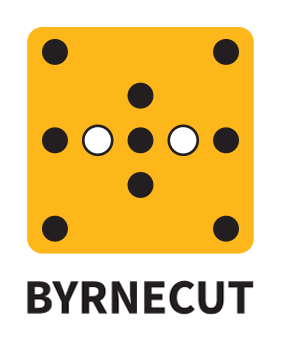

## Overview
This project is to produce a model for Byrnecut Australia Pty Ltd. that is able to determine the expected development advance for a week period based on different features. Using this model Byrnecut is able to accurately predict weekly expectations which will help with forecasting and management of their workforce

## Business Problem
Byrnecut wants to gain a better understanding of expectations for their development based on manning levels and heading availability.

## Data Understanding

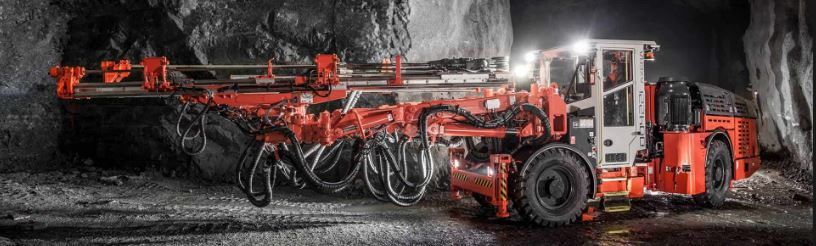

### Definitions:
 - **Jumbo** - A piece of machinery used to drill holes to put explosives in to break down dirt underground, shown in the photo above. This machine also installs ground support to protect mining personnel underground
 - **Advance** - How far we progress underground, the **Jumbo** drills holes in the face of the rock which is then filled with explosives. Once the explosives are set off we call this a 'cut'. Each 'cut' we take, is approximately 4m of advance
 - **Front Liner** - A front liner is our fully trained/highly skilled operators on the Jumbo
 - **Trainee** - A new jumbo operator, not as experienced so not as productive as a Front Liner
 - **DRM** - Drill Metres, the sum of ream and face holes drilled
 
### Column Names and descriptions for the JumboData dataset
- **Equipment ID** - The equipment number for each jumbo used
- **Front Liner?** - Whether or not a front liner was operating the jumbo
- **Source Locations** - The location that the activity was taking place
- **Product Group** - Whether the blasted rock was Ore or Waste material
- **Face Hole Drilled** - The quantity of blast holes drilled in the face
- **Ream hole Drilled** - The quantity of reaming holes drilled in the face
- **Hole Length** - The length of the holes being drilled in the face
- **Charged Holes** - The quantity of holes that are filled with explosives for each cut
- **Advance** - The amount of advance gained in each cut
- **Wet Holes** - Not used in underground mining here.
- **Activity** - The type of advance, whether its for a main decline or small ore drives etc.
- **Shift Date** - The date of the advance
- **Shift Type** - The type of shift, either Day shift or Night Shift
- **Week** - The week from the beginning of our contract
- **Site ID** - Our site number

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
from scipy import stats
import scipy as sp
from statsmodels.formula.api import ols
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt


In [2]:
from functions import encode, evaluate

In [3]:
jumbo_df = pd.read_csv('data/JumboData.csv')

In [4]:
jumbo_df.head()

,Equipment ID,Front Liner?,Source Locations,Product Group,Face Hole Drilled,Ream Hole Drilled,Hole Length,Charged Holes,Advance,Wet Holes,Activity,Shift Date,Shift Type,Week,Site Id
0,DD016,NaN,N-81,NaN,105,6,4.5,0.0,0.0,0,Decline Development,4/07/2017,Day 12Hr,1,WBINC
1,DD016,NaN,N-86,NaN,105,6,4.5,0.0,0.0,0,Decline Development,4/07/2017,Day 12Hr,1,WBINC
2,DD016,NaN,N-86,NaN,0,0,4.5,105.0,3.1,0,Decline Development,5/07/2017,Day 12Hr,2,WBINC
3,DD016,NaN,N-81,NaN,0,0,4.5,105.0,3.1,0,Decline Development,5/07/2017,Day 12Hr,2,WBINC
4,DD016,NaN,N-86,NaN,0,0,4.5,0.0,0.0,0,Decline Development,7/07/2017,Day 12Hr,2,WBINC


## Data Preparation
### Data Cleaning
I Start by editing the format of the column names to allow them to be read(Removing spaces)

In [5]:
jumbo_df.columns = jumbo_df.columns.str.replace(' ','_')
jumbo_df.columns = jumbo_df.columns.str.replace('?','')

In [6]:
jumbo_df.columns

Index(['Equipment_ID', 'Front_Liner', 'Source_Locations', 'Product_Group',
       'Face_Hole_Drilled', 'Ream_Hole_Drilled', 'Hole_Length',
       'Charged_Holes', 'Advance', 'Wet_Holes', 'Activity', 'Shift_Date',
       'Shift_Type', 'Week', 'Site_Id'],
      dtype='object')

In [7]:
jumbo_df['Equipment_ID'].value_counts()

DD023         9792
DD016         8595
DD036         7391
DD065         4447
DD024         3796
DD076         3152
INC_GROUT1    2485
DD107          658
INV_CBCrew     491
INV_Paste      151
DD027           91
DD037           41
INC_DevCh       39
DL017            1
Name: Equipment_ID, dtype: int64

**Lets only use rows that contain "DD", this means that the equipment is actually what we use for advancing**

In [8]:
olen = len(jumbo_df['Equipment_ID'])
jumbo_df = jumbo_df[jumbo_df['Equipment_ID'].str.contains("DD")==True]
nlen = len(jumbo_df['Equipment_ID'])

diff = olen-nlen

print('Original Length:',olen,'rows')
print('New length:',nlen,'rows')
print('We removed:',diff,'rows')

Original Length: 41130 rows
New length: 37963 rows
We removed: 3167 rows


**Now lets have a look at the null values**

In [9]:
jumbo_df.isnull().sum()

Equipment_ID             0
Front_Liner           5600
Source_Locations         0
Product_Group        37847
Face_Hole_Drilled        0
Ream_Hole_Drilled        0
Hole_Length              0
Charged_Holes         3748
Advance                  0
Wet_Holes                0
Activity                 0
Shift_Date               0
Shift_Type               0
Week                     0
Site_Id                  0
dtype: int64

Ill start by replacing the Front Liner null values with the mode

In [10]:
jumbo_df['Front_Liner'].value_counts()

Yes    27240
No      5123
Name: Front_Liner, dtype: int64

In [11]:
jumbo_df['Front_Liner'] = jumbo_df['Front_Liner'].fillna('Yes')

Im now going to drop the product group column as almost every value is null

In [12]:
jumbo_df.drop('Product_Group',axis=1,inplace=True)

In [13]:
jumbo_df['Charged_Holes'].value_counts()

0.0      20557
66.0      1515
68.0       900
70.0       807
62.0       772
         ...  
161.0        1
102.0        1
3.7          1
103.0        1
101.0        1
Name: Charged_Holes, Length: 110, dtype: int64

In [14]:
jumbo_df['Charged_Holes'].median()

0.0

As the median is 0, and i know for a fact that it shouldnt be. Im going to remove this column aswell

In [15]:
jumbo_df.drop('Charged_Holes',axis=1,inplace=True)

so where does that leave us?

In [16]:
jumbo_df.head()

,Equipment_ID,Front_Liner,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Wet_Holes,Activity,Shift_Date,Shift_Type,Week,Site_Id
0,DD016,Yes,N-81,105,6,4.5,0.0,0,Decline Development,4/07/2017,Day 12Hr,1,WBINC
1,DD016,Yes,N-86,105,6,4.5,0.0,0,Decline Development,4/07/2017,Day 12Hr,1,WBINC
2,DD016,Yes,N-86,0,0,4.5,3.1,0,Decline Development,5/07/2017,Day 12Hr,2,WBINC
3,DD016,Yes,N-81,0,0,4.5,3.1,0,Decline Development,5/07/2017,Day 12Hr,2,WBINC
4,DD016,Yes,N-86,0,0,4.5,0.0,0,Decline Development,7/07/2017,Day 12Hr,2,WBINC


From further knowledge, i am determining that wet holes and site id are irellevant

In [17]:
jumbo_df.drop(['Wet_Holes','Site_Id'],axis=1,inplace=True)

In [18]:
jumbo_df.head()

,Equipment_ID,Front_Liner,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Activity,Shift_Date,Shift_Type,Week
0,DD016,Yes,N-81,105,6,4.5,0.0,Decline Development,4/07/2017,Day 12Hr,1
1,DD016,Yes,N-86,105,6,4.5,0.0,Decline Development,4/07/2017,Day 12Hr,1
2,DD016,Yes,N-86,0,0,4.5,3.1,Decline Development,5/07/2017,Day 12Hr,2
3,DD016,Yes,N-81,0,0,4.5,3.1,Decline Development,5/07/2017,Day 12Hr,2
4,DD016,Yes,N-86,0,0,4.5,0.0,Decline Development,7/07/2017,Day 12Hr,2


In [19]:
jumbo_df.groupby('Activity')['Advance'].sum()

Activity
Advance Through Paste - Bogger        40.00
Auto Drilling over shift change        8.00
Cablebolt I & G                        0.00
Decline Development                 5366.00
Decline Rehab                          4.00
Electrical Cuddy                      43.00
FD - Ore Development < 5.2m         2174.00
FD - Ore Development > 5.2m         2213.00
FD - Paste Development < 5.2m        202.00
FD - Paste Development > 5.2m         47.00
FD - Waste Development < 5.2m        560.20
FD - Waste Development > 5.2m       5074.50
Face Support                           8.00
Fan Hanger                             0.00
GS - Ore Development <5.2m             8.00
GS - Ore Development > 5.2m            4.00
GS - Paste Development <5.2m           0.00
GS - Paste Development > 5.2m          4.00
GS - Waste Development < 5.2m          7.00
GS - Waste development > 5.2m         15.00
Incline Development                  816.80
Level Development                  17434.00
Level Rehab            

Ok so there is alot of activies here. Im going to split this up into 2 different types. 
* Large Development
* Small Development

In [20]:
development_types = ['Large_Development','Small_Development']

In [21]:
Large_Development = ['Decline Development', 'Decline Rehab','FD - Ore Development > 5.2m',
                    'FD - Waste Development > 5.2m', 'Incline Development', 'Ore Development >5.2m',
                    'Waste Development >5.2m','Stripping']
Small_Development = ['Level Development','Level Rehab','FD - Ore Development < 5.2m','FD - Waste Development < 5.2m',
                     'Ore Development <5.2m','Waste Development <5.2m', 'Ore Development']

In [22]:
jumbo_df.loc[jumbo_df['Activity'].isin(Large_Development),'Activity'] = 'Large_Development'
jumbo_df.loc[jumbo_df['Activity'].isin(Small_Development),'Activity'] = 'Small_Development'

In [23]:
jumbo_df

,Equipment_ID,Front_Liner,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Activity,Shift_Date,Shift_Type,Week
0,DD016,Yes,N-81,105,6,4.5,0.0,Large_Development,4/07/2017,Day 12Hr,1
1,DD016,Yes,N-86,105,6,4.5,0.0,Large_Development,4/07/2017,Day 12Hr,1
2,DD016,Yes,N-86,0,0,4.5,3.1,Large_Development,5/07/2017,Day 12Hr,2
3,DD016,Yes,N-81,0,0,4.5,3.1,Large_Development,5/07/2017,Day 12Hr,2
4,DD016,Yes,N-86,0,0,4.5,0.0,Large_Development,7/07/2017,Day 12Hr,2
...,...,...,...,...,...,...,...,...,...,...,...
41125,DD023,Yes,8932 GIB ACO,69,6,4.3,4.0,Large_Development,30/09/2022,Night 12Hr,275
41126,DD023,Yes,8862 GIB ACC,0,0,4.3,0.0,GS - Waste development > 5.2m,30/09/2022,Night 12Hr,275
41127,DD107,Yes,8942 GIB SD 9,64,6,4.3,4.0,Small_Development,30/09/2022,Night 12Hr,275
41128,DD065,Yes,8810 FTN ODS 3,0,0,4.3,0.0,GS - Ore Development <5.2m,30/09/2022,Night 12Hr,275


In [24]:
jumbo_df.groupby('Activity')['Advance'].sum()

Activity
Advance Through Paste - Bogger        40.00
Auto Drilling over shift change        8.00
Cablebolt I & G                        0.00
Electrical Cuddy                      43.00
FD - Paste Development < 5.2m        202.00
FD - Paste Development > 5.2m         47.00
Face Support                           8.00
Fan Hanger                             0.00
GS - Ore Development <5.2m             8.00
GS - Ore Development > 5.2m            4.00
GS - Paste Development <5.2m           0.00
GS - Paste Development > 5.2m          4.00
GS - Waste Development < 5.2m          7.00
GS - Waste development > 5.2m         15.00
Large_Development                  16698.30
Mesh Rise                              0.00
PROBE                                  0.00
Paste Development                    191.40
Paste Development < 5.2m              38.70
Paste Development > 5.2m               0.01
Paste Wall Firing                     58.50
Pops                                   3.00
Service Hangers        

Lets remove all activities that dont fall into these groups. Paste Development will not be included in this as that is usually completed by a loader. The other activity times i can say were more than likely issues with data entry

In [25]:
jumbo_df.drop(jumbo_df[(jumbo_df['Activity'] != 'Large_Development') & (jumbo_df['Activity'] != 'Small_Development')].index,
             inplace=True)  

In [26]:
jumbo_df.groupby('Activity')['Advance'].sum()

Activity
Large_Development    16698.3
Small_Development    39370.5
Name: Advance, dtype: float64

Much better!

Now my dataset is starting to take shape, lets have a look at the data types

In [27]:
jumbo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33191 entries, 0 to 41129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Equipment_ID       33191 non-null  object 
 1   Front_Liner        33191 non-null  object 
 2   Source_Locations   33191 non-null  object 
 3   Face_Hole_Drilled  33191 non-null  int64  
 4   Ream_Hole_Drilled  33191 non-null  int64  
 5   Hole_Length        33191 non-null  float64
 6   Advance            33191 non-null  float64
 7   Activity           33191 non-null  object 
 8   Shift_Date         33191 non-null  object 
 9   Shift_Type         33191 non-null  object 
 10  Week               33191 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 3.0+ MB


**lets make the following changes:**
- Shift Date to datetime

In [28]:
jumbo_df['Shift_Date'] = pd.to_datetime(jumbo_df['Shift_Date'], format='%d/%m/%Y')

In [29]:
jumbo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33191 entries, 0 to 41129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Equipment_ID       33191 non-null  object        
 1   Front_Liner        33191 non-null  object        
 2   Source_Locations   33191 non-null  object        
 3   Face_Hole_Drilled  33191 non-null  int64         
 4   Ream_Hole_Drilled  33191 non-null  int64         
 5   Hole_Length        33191 non-null  float64       
 6   Advance            33191 non-null  float64       
 7   Activity           33191 non-null  object        
 8   Shift_Date         33191 non-null  datetime64[ns]
 9   Shift_Type         33191 non-null  object        
 10  Week               33191 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 3.0+ MB


Much better!

Now lets add some useful columns

A DRM(Drill metre) column will show us the drill metres for each shift

In [30]:
jumbo_df['DRM'] = (jumbo_df['Face_Hole_Drilled'] + jumbo_df['Ream_Hole_Drilled']) * jumbo_df['Hole_Length']

lets have a look at how some of these look graphed?

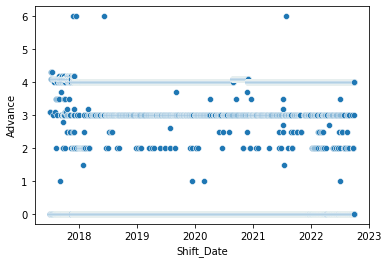

In [31]:
sns.scatterplot(data=jumbo_df,x='Shift_Date',y='Advance');

This doesnt really look helpful, we need a sum of the advance for each shift, lets create a new dataframe..

In [32]:
jumbo_df.head()

,Equipment_ID,Front_Liner,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Activity,Shift_Date,Shift_Type,Week,DRM
0,DD016,Yes,N-81,105,6,4.5,0.0,Large_Development,2017-07-04,Day 12Hr,1,499.5
1,DD016,Yes,N-86,105,6,4.5,0.0,Large_Development,2017-07-04,Day 12Hr,1,499.5
2,DD016,Yes,N-86,0,0,4.5,3.1,Large_Development,2017-07-05,Day 12Hr,2,0.0
3,DD016,Yes,N-81,0,0,4.5,3.1,Large_Development,2017-07-05,Day 12Hr,2,0.0
4,DD016,Yes,N-86,0,0,4.5,0.0,Large_Development,2017-07-07,Day 12Hr,2,0.0


lets remove the lines with no advance

In [33]:
jumbo_df.drop(jumbo_df[jumbo_df['Advance'] == 0].index, inplace=True)

#### Transformations
Im now going to establish a new dataframe. As i want to be able to determine the expected advance for days or weeks, i need to set the initial dataframe up for daily figures

In [34]:
#Establish a dataframe
j_df = pd.DataFrame()

In [35]:
#Add a column of unique dates based on the initial dataframes dates
j_df['date'] = jumbo_df['Shift_Date'].unique()

In [36]:
#Create a list of advances for each unique date
advances = []

for dates in j_df['date']:
    advances.append(np.where(jumbo_df['Shift_Date']==dates, jumbo_df['Advance'],0).sum())

In [37]:
#Create a list of Drill metres for each unique date
DRM = []

for dates in j_df['date']:
    DRM.append(np.where(jumbo_df['Shift_Date']==dates, jumbo_df['DRM'],0).sum())

In [38]:
#Append the previously made lists into the new dataframe columns
j_df['advance'] = advances
j_df['drm'] = DRM

In [39]:
j_df.head()

,date,advance,drm
0,2017-07-05,6.2,0.0
1,2017-07-09,4.1,378.0
2,2017-07-10,4.1,378.0
3,2017-07-13,4.3,193.5
4,2017-07-14,4.3,216.0


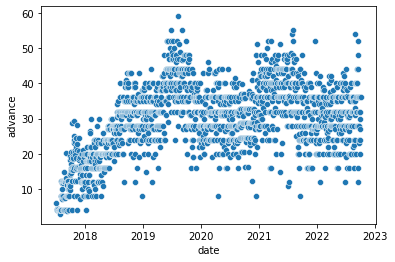

In [40]:
#A plot of advance over time
sns.scatterplot(data=j_df,x='date',y='advance');

In [41]:
#Create a new column for required drill metres per advance
j_df['drm/advance'] = j_df['drm']/j_df['advance']

In [42]:
#Create a column that calculates the amount of drill rigs used for each day
rigs = jumbo_df.groupby(['Shift_Date'])['Equipment_ID'].nunique().tolist()
j_df['drills'] = rigs

In [43]:
#Create a column for the drill metres for each drill used
j_df['drm/drill'] = j_df['drm']/j_df['drills']

In [44]:
#Create a column for the advance per drill used
j_df['adv/drill'] = j_df['advance']/j_df['drills']

In [45]:
j_df.head()

,date,advance,drm,drm/advance,drills,drm/drill,adv/drill
0,2017-07-05,6.2,0.0,0.000000,1,0.0,6.2
1,2017-07-09,4.1,378.0,92.195122,1,378.0,4.1
2,2017-07-10,4.1,378.0,92.195122,1,378.0,4.1
3,2017-07-13,4.3,193.5,45.000000,1,193.5,4.3
4,2017-07-14,4.3,216.0,50.232558,1,216.0,4.3


For regression plots i cant use date time, so i'll need to add a 'date delta' column

In [46]:
#Create a 'date delta' column, this calculates how many days since the start of the contract
j_df['date_delta'] = (j_df['date']-j_df['date'].min()) / np.timedelta64(1,'D')

In [47]:
jumbo_df.head()

,Equipment_ID,Front_Liner,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Activity,Shift_Date,Shift_Type,Week,DRM
2,DD016,Yes,N-86,0,0,4.5,3.1,Large_Development,2017-07-05,Day 12Hr,2,0.0
3,DD016,Yes,N-81,0,0,4.5,3.1,Large_Development,2017-07-05,Day 12Hr,2,0.0
7,DD016,Yes,Drake Decline,78,6,4.5,4.1,Large_Development,2017-07-09,Day 12Hr,2,378.0
10,DD016,Yes,FENTON DECLINE,78,6,4.5,4.1,Large_Development,2017-07-10,Day 12Hr,2,378.0
15,DD016,Yes,Drake Decline,43,0,4.5,4.3,Large_Development,2017-07-13,Day 12Hr,3,193.5


### Transforming Categorical Data
Below i will have a look at the front liner and activity columns

In [48]:
#OneHotEncode the FrontLiner column
frontline_encode = encode(jumbo_df,'Front_Liner')

In [49]:
#OneHotEncode the acitivty
size_encode = encode(jumbo_df,'Activity')

In [50]:
#OneHotEncode the quantity of drills
drills_encode = encode(j_df,'drills')

In [51]:
#Concatenate these to the original dataframe
jumbo_df = pd.concat([jumbo_df,frontline_encode],axis=1).drop(columns='Front_Liner')
jumbo_df = pd.concat([jumbo_df,size_encode],axis=1).drop(columns='Activity')
j_df = pd.concat([j_df,drills_encode],axis=1).drop(columns='drills')

In [52]:
jumbo_df['No'] = 1 - jumbo_df['Yes']

In [53]:
jumbo_df

,Equipment_ID,Source_Locations,Face_Hole_Drilled,Ream_Hole_Drilled,Hole_Length,Advance,Shift_Date,Shift_Type,Week,DRM,Yes,Small_Development,No
2,DD016,N-86,0,0,4.5,3.1,2017-07-05,Day 12Hr,2,0.0,1.0,0.0,0.0
3,DD016,N-81,0,0,4.5,3.1,2017-07-05,Day 12Hr,2,0.0,1.0,0.0,0.0
7,DD016,Drake Decline,78,6,4.5,4.1,2017-07-09,Day 12Hr,2,378.0,1.0,0.0,0.0
10,DD016,FENTON DECLINE,78,6,4.5,4.1,2017-07-10,Day 12Hr,2,378.0,1.0,0.0,0.0
15,DD016,Drake Decline,43,0,4.5,4.3,2017-07-13,Day 12Hr,3,193.5,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41121,DD076,8734 NEL RAA,88,6,4.3,4.0,2022-09-30,Night 12Hr,275,404.2,1.0,0.0,0.0
41123,DD065,8810 FTN ODS 2,57,6,4.3,4.0,2022-09-30,Night 12Hr,275,270.9,1.0,1.0,0.0
41124,DD107,8943 DUN STC,64,6,4.3,4.0,2022-09-30,Night 12Hr,275,301.0,1.0,0.0,0.0
41125,DD023,8932 GIB ACO,69,6,4.3,4.0,2022-09-30,Night 12Hr,275,322.5,1.0,0.0,0.0


### Further Transformations between dataframes

In [54]:
#Create two lists, one for front liner advance and one for trainee advance
yes = []
no = []
for dates in j_df['date']:
    yes.append(np.where(((jumbo_df['Shift_Date']==dates) & (jumbo_df['Yes']==1)), jumbo_df['Advance'],0).sum())
    no.append(np.where(((jumbo_df['Shift_Date']==dates) & (jumbo_df['Yes']!=1)), jumbo_df['Advance'],0).sum())
    

In [55]:
#Add these two lists to our new dataframe
j_df['frontline_adv'] = yes
j_df['trainee_adv'] = no

In [56]:
#Create two lists, one for small sized advance and one for large sized advance
small = []
large = []
for dates in j_df['date']:
    small.append(np.where(((jumbo_df['Shift_Date']==dates) & (jumbo_df['Small_Development']==1)), jumbo_df['Advance'],0).sum())
    large.append(np.where(((jumbo_df['Shift_Date']==dates) & (jumbo_df['Small_Development']!=1)), jumbo_df['Advance'],0).sum())

In [57]:
#Add these two lists to our new dataframe
j_df['small_adv'] = small
j_df['large_adv'] = large

In [58]:
j_df.head()

,date,advance,drm,drm/advance,drm/drill,adv/drill,date_delta,2,3,4,5,frontline_adv,trainee_adv,small_adv,large_adv
0,2017-07-05,6.2,0.0,0.000000,0.0,6.2,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,6.2
1,2017-07-09,4.1,378.0,92.195122,378.0,4.1,4.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1
2,2017-07-10,4.1,378.0,92.195122,378.0,4.1,5.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1
3,2017-07-13,4.3,193.5,45.000000,193.5,4.3,8.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3
4,2017-07-14,4.3,216.0,50.232558,216.0,4.3,9.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3


In [59]:
#Create a list that assigns the week number to each date in our new dataframe
x = jumbo_df.groupby('Shift_Date')['Week'].sum()
y = jumbo_df.groupby('Shift_Date')['Week'].count()
week = (x/y).tolist()
j_df['week'] = week

In [60]:
#Create a list of headings for each week
week_list = pd.unique(jumbo_df['Week']).tolist()
avail_headings = jumbo_df.groupby('Week')['Source_Locations'].nunique().tolist()

print(len(week_list))
len((avail_headings))

274


274

In [61]:
#Create a dictionary based on week number and headings available for that week
week_dict = {}
for key in week_list:
    for value in avail_headings:
        week_dict[key] = value
        avail_headings.remove(value)
        break

In [62]:
#Add a new column that will be for the headings available, but lets just take over the week number first
j_df['weekly_headings'] = j_df['week']
j_df.head(10)

,date,advance,drm,drm/advance,drm/drill,adv/drill,date_delta,2,3,4,5,frontline_adv,trainee_adv,small_adv,large_adv,week,weekly_headings
0,2017-07-05,6.2,0.0,0.000000,0.0,6.2,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,6.2,2.0,2.0
1,2017-07-09,4.1,378.0,92.195122,378.0,4.1,4.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,2.0,2.0
2,2017-07-10,4.1,378.0,92.195122,378.0,4.1,5.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,2.0,2.0
3,2017-07-13,4.3,193.5,45.000000,193.5,4.3,8.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3,3.0,3.0
4,2017-07-14,4.3,216.0,50.232558,216.0,4.3,9.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3,3.0,3.0
5,2017-07-16,4.3,387.0,90.000000,387.0,4.3,11.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3,3.0,3.0
6,2017-07-21,4.1,346.5,84.512195,346.5,4.1,16.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,4.0,4.0
7,2017-07-22,4.1,391.5,95.487805,391.5,4.1,17.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,4.0,4.0
8,2017-07-23,4.1,382.5,93.292683,382.5,4.1,18.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,4.0,4.0
9,2017-07-25,4.1,387.0,94.390244,387.0,4.1,20.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,4.0,4.0


In [63]:
#Now lets use our dictionary we just made to replace the week number with the headings
j_df.replace({'weekly_headings': week_dict}, inplace=True)

In [64]:
#lets create a column for th percentage of advance assigned to frontliners 
j_df['%frontline'] = j_df['frontline_adv'] / (j_df['frontline_adv'] + j_df['trainee_adv'])

In [65]:
#And a column for the percentage of advance assigned to trainees
j_df['%trainee'] = 1 - j_df['%frontline']

In [66]:
#Now create a column for the percentage of advance that is classed as 'small advance'
j_df['%small'] = j_df['small_adv'] / (j_df['small_adv'] + j_df['large_adv'])

In [67]:
sns.set_theme()

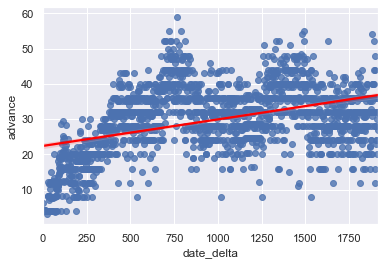

In [68]:
#Lets run through some various trends in the dataset
sns.regplot(data=j_df,x='date_delta',y='advance',
           line_kws={'color':'red'});

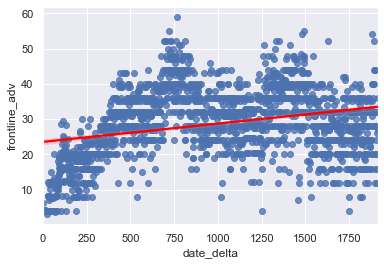

In [69]:
sns.regplot(data=j_df,x='date_delta',y='frontline_adv',
           line_kws={'color':'red'});

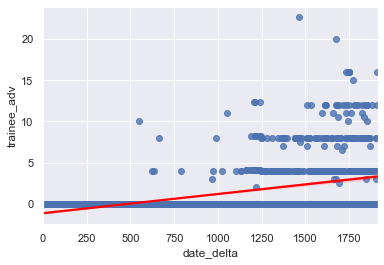

In [70]:
sns.regplot(data=j_df,x='date_delta',y='trainee_adv',
           line_kws={'color':'red'});

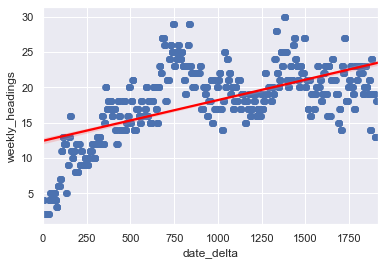

In [71]:
sns.regplot(data=j_df,x='date_delta',y='weekly_headings',
           line_kws={'color':'red'});

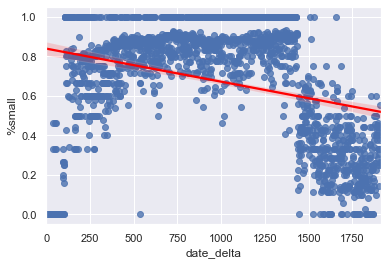

In [72]:
sns.regplot(data=j_df,x='date_delta',y='%small',
           line_kws={'color':'red'});

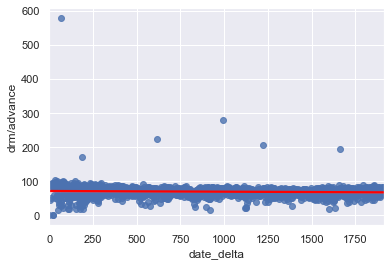

In [73]:
sns.regplot(data=j_df,x='date_delta',y='drm/advance',
           line_kws={'color':'red'});

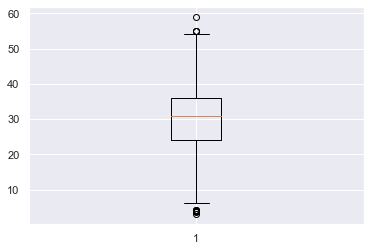

In [74]:
#Create a boxplot to identify outliers in our advance
plt.boxplot(j_df['advance']);

Lets remove any outliers

In [75]:
# Removing any advances that have a z score higher than 3
j_df = j_df[(np.abs(stats.zscore(j_df['advance'])) < 3)]

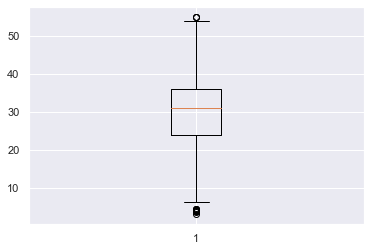

In [76]:
plt.boxplot(j_df['advance']);

much better!

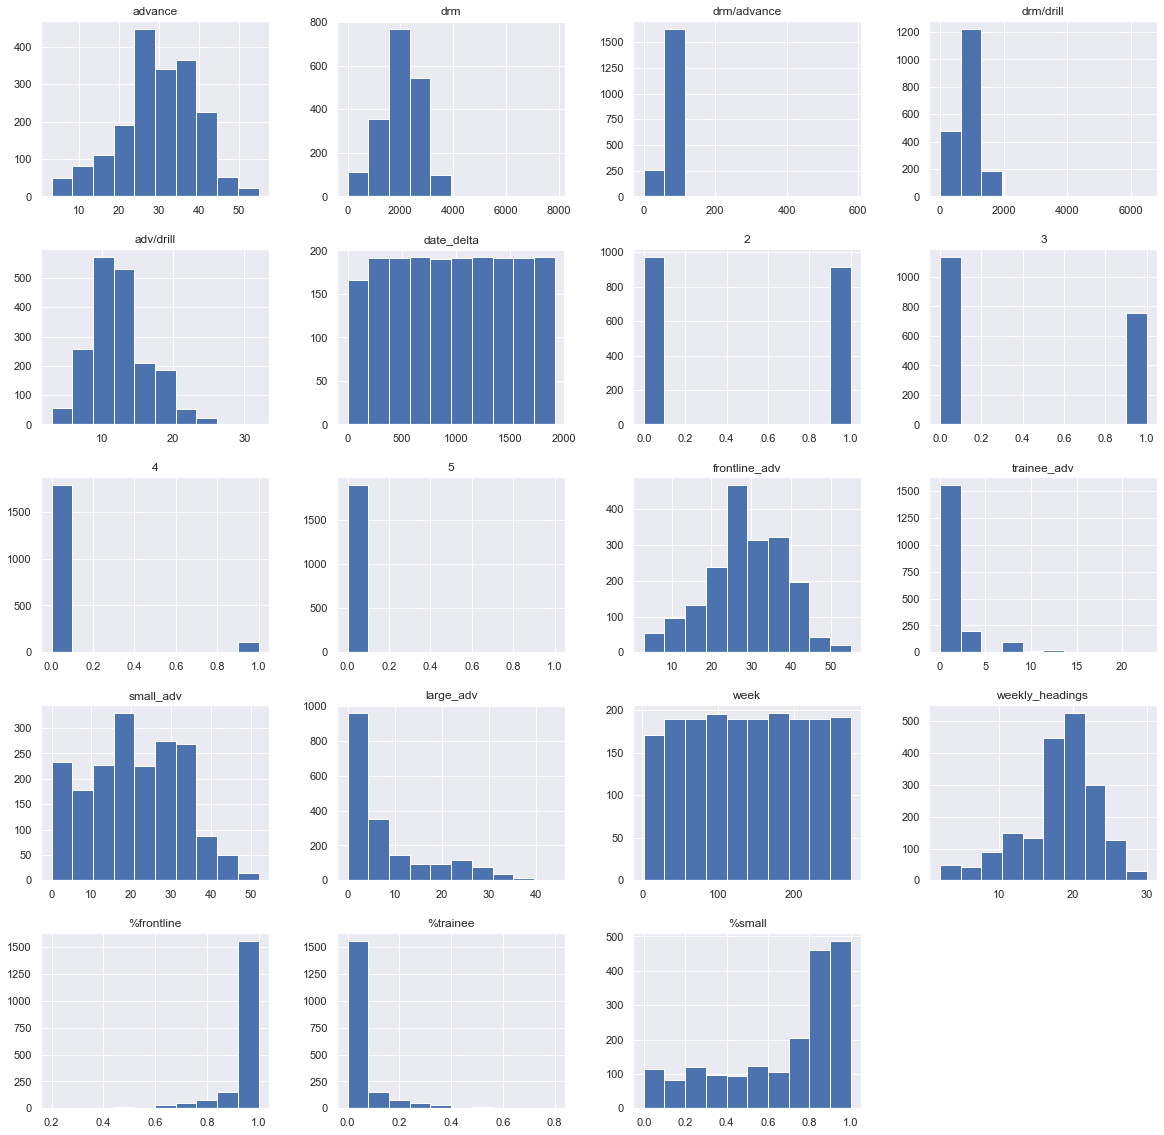

In [77]:
#Creating histograms for each feature
j_df.hist(figsize=(20,20));

In [78]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [79]:
j_df.head()

,date,advance,drm,drm/advance,drm/drill,adv/drill,date_delta,2,3,4,5,frontline_adv,trainee_adv,small_adv,large_adv,week,weekly_headings,%frontline,%trainee,%small
0,2017-07-05,6.2,0.0,0.000000,0.0,6.2,0.0,0.0,0.0,0.0,0.0,6.2,0.0,0.0,6.2,2.0,4.0,1.0,0.0,0.0
1,2017-07-09,4.1,378.0,92.195122,378.0,4.1,4.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,2.0,4.0,1.0,0.0,0.0
2,2017-07-10,4.1,378.0,92.195122,378.0,4.1,5.0,0.0,0.0,0.0,0.0,4.1,0.0,0.0,4.1,2.0,4.0,1.0,0.0,0.0
3,2017-07-13,4.3,193.5,45.000000,193.5,4.3,8.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3,3.0,2.0,1.0,0.0,0.0
4,2017-07-14,4.3,216.0,50.232558,216.0,4.3,9.0,0.0,0.0,0.0,0.0,4.3,0.0,0.0,4.3,3.0,2.0,1.0,0.0,0.0


### Correlations

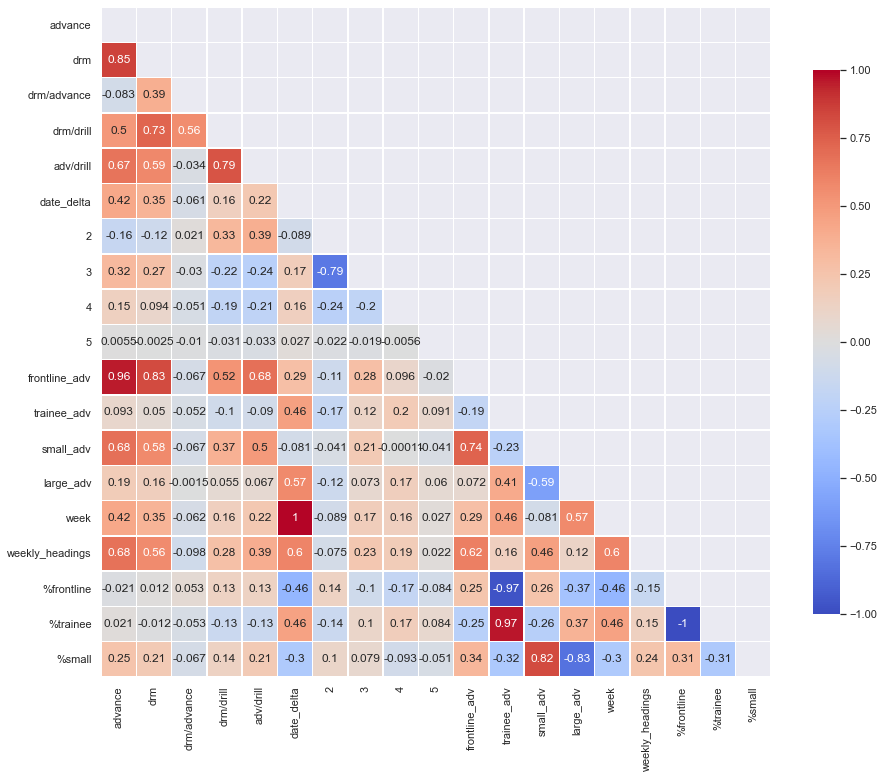

In [80]:
#Create a heat map that shows correlations between features
corr = j_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

Alright, im going to drop columns that are no longer required

In [81]:
#These columns are no longer required as i have percentages for each one
j_df.drop(columns=['frontline_adv','trainee_adv','small_adv','large_adv'], inplace=True)
j_df.head()

,date,advance,drm,drm/advance,drm/drill,adv/drill,date_delta,2,3,4,5,week,weekly_headings,%frontline,%trainee,%small
0,2017-07-05,6.2,0.0,0.000000,0.0,6.2,0.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,0.0
1,2017-07-09,4.1,378.0,92.195122,378.0,4.1,4.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,0.0
2,2017-07-10,4.1,378.0,92.195122,378.0,4.1,5.0,0.0,0.0,0.0,0.0,2.0,4.0,1.0,0.0,0.0
3,2017-07-13,4.3,193.5,45.000000,193.5,4.3,8.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0
4,2017-07-14,4.3,216.0,50.232558,216.0,4.3,9.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0


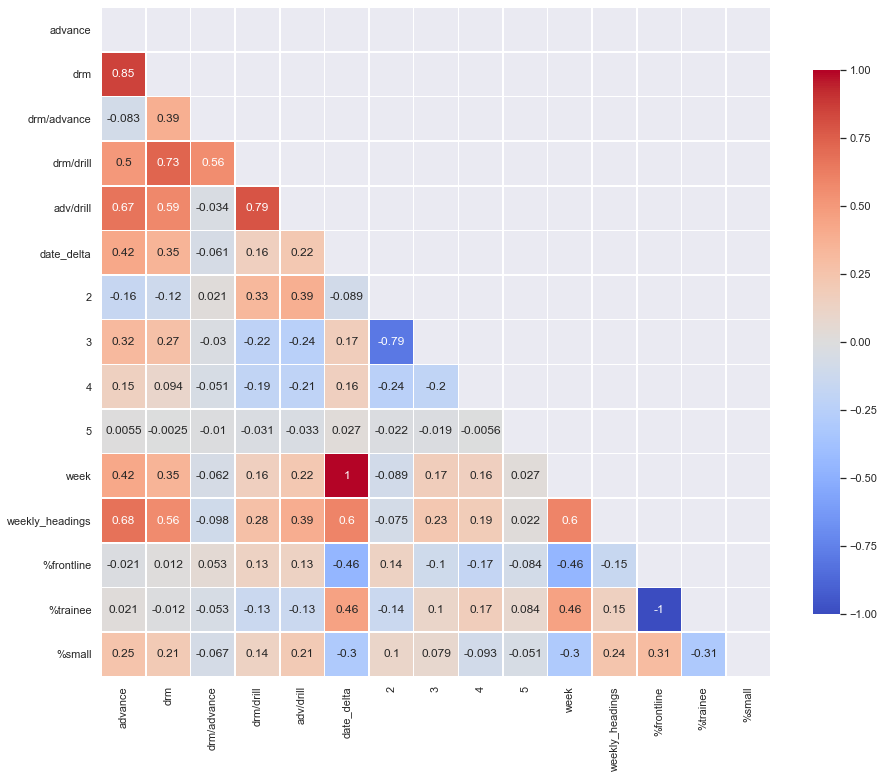

In [82]:
#Looking at the heatmap again with these columns removed
corr = j_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

Now im going to remove negatively corrrelating features

In [83]:
#Dropping negatively correlated features
j_df.drop(columns=[2,'drm/advance','%frontline'], inplace=True)
j_df.head()

,date,advance,drm,drm/drill,adv/drill,date_delta,3,4,5,week,weekly_headings,%trainee,%small
0,2017-07-05,6.2,0.0,0.0,6.2,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
1,2017-07-09,4.1,378.0,378.0,4.1,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
2,2017-07-10,4.1,378.0,378.0,4.1,5.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
3,2017-07-13,4.3,193.5,193.5,4.3,8.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,2017-07-14,4.3,216.0,216.0,4.3,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0


Ok, although DRM highly correlates with the advance, we arent provided with that information each week.. All we will know is the quantity of drills running, the size of the drives and the skill of the drill operators. lets remove the remainder of unusable columns.

In [84]:
j_df.drop(columns=['drm','drm/drill','adv/drill'], inplace=True)

In [85]:
j_df.head()

,date,advance,date_delta,3,4,5,week,weekly_headings,%trainee,%small
0,2017-07-05,6.2,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
1,2017-07-09,4.1,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
2,2017-07-10,4.1,5.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
3,2017-07-13,4.3,8.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,2017-07-14,4.3,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0


Lets rename the columns so they can be analysed by OLS

In [86]:
#OLS wasnt allowing me to use numbers or symbols in the formula
j_df.rename(columns={'%trainee':'perc_trainee','%small':'perc_small',3:'three_rigs',4:'four_rigs',5:'five_rigs'}, inplace=True)

In [87]:
j_df.head()

,date,advance,date_delta,three_rigs,four_rigs,five_rigs,week,weekly_headings,perc_trainee,perc_small
0,2017-07-05,6.2,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
1,2017-07-09,4.1,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
2,2017-07-10,4.1,5.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
3,2017-07-13,4.3,8.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,2017-07-14,4.3,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0


### Base Model

In [88]:
#Create an OLS table for our base model
outcome = 'advance'
x_cols = ['date_delta','week','weekly_headings','perc_trainee','perc_small','three_rigs','four_rigs','five_rigs']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=j_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                advance   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     278.2
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          3.96e-312
Time:                        08:27:09   Log-Likelihood:                -6232.5
No. Observations:                1887   AIC:                         1.248e+04
Df Residuals:                    1878   BIC:                         1.253e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          13.9678      1.027     13.594      0.000      11.953      15.983
date_delta          0.7263      0.076      9.551      0.000       0.577       0.875
week               -5.0620      0.532     -9.509      0.000      -6.106      -4.018
weekly_headings     0.9052      0.045     20.267      0.000       0.818       0.993
perc_trainee      -13.7288      1.920     -7.150      0.000     -17.494      -9.963
perc_small          4.3966      0.632      6.952      0.000       3.156       5.637
three_rigs          3.8925      0.332     11.721      0.000       3.241       4.544
four_rigs           4.3835      0.706      6.206      0.000       2.998       5.769
five_rigs           5.1773      6.637      0.780      0.435      -7.839      18.193
==============================================================================
Omnibus:                        2.855   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                3.011
Skew:                          -0.027   Prob(JB):                        0.222
Kurtosis:                       3.188   Cond. No.                     4.91e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

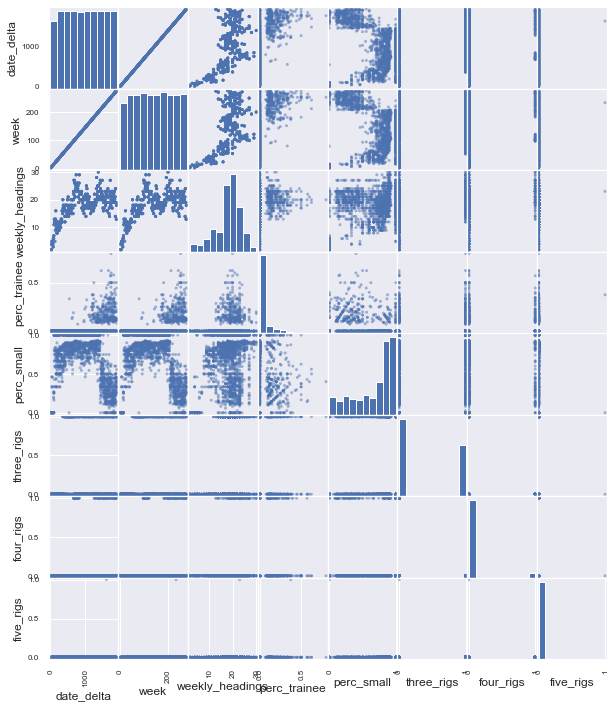

In [89]:
pd.plotting.scatter_matrix(j_df[x_cols], figsize=(10,12));

In [90]:
#Create a correlation table for our basemodel
j_df.corr()

,advance,date_delta,three_rigs,four_rigs,five_rigs,week,weekly_headings,perc_trainee,perc_small
advance,1.000000,0.423218,0.320313,0.152849,0.005489,0.422632,0.676773,0.020708,0.252344
date_delta,0.423218,1.000000,0.173087,0.162943,0.027150,0.999993,0.599673,0.458345,-0.297513
three_rigs,0.320313,0.173087,1.000000,-0.200010,-0.018785,0.172957,0.227637,0.103076,0.079121
four_rigs,0.152849,0.162943,-0.200010,1.000000,-0.005646,0.162907,0.189322,0.172681,-0.093212
five_rigs,0.005489,0.027150,-0.018785,-0.005646,1.000000,0.027150,0.021787,0.084086,-0.050720
week,0.422632,0.999993,0.172957,0.162907,0.027150,1.000000,0.599660,0.458348,-0.297549
weekly_headings,0.676773,0.599673,0.227637,0.189322,0.021787,0.599660,1.000000,0.149964,0.243671
perc_trainee,0.020708,0.458345,0.103076,0.172681,0.084086,0.458348,0.149964,1.000000,-0.311287
perc_small,0.252344,-0.297513,0.079121,-0.093212,-0.050720,-0.297549,0.243671,-0.311287,1.000000


In [91]:
#Identify correlations above 80%
abs(j_df.corr()) >.8 

,advance,date_delta,three_rigs,four_rigs,five_rigs,week,weekly_headings,perc_trainee,perc_small
advance,True,False,False,False,False,False,False,False,False
date_delta,False,True,False,False,False,True,False,False,False
three_rigs,False,False,True,False,False,False,False,False,False
four_rigs,False,False,False,True,False,False,False,False,False
five_rigs,False,False,False,False,True,False,False,False,False
week,False,True,False,False,False,True,False,False,False
weekly_headings,False,False,False,False,False,False,True,False,False
perc_trainee,False,False,False,False,False,False,False,True,False
perc_small,False,False,False,False,False,False,False,False,True


#### Ok so lets investigate date_delta and week.

week & date delta = 0.999993

Well obviously these will correlate as the week is based off of dates..

#### What are their correlation to advance?

date_delta (0.423218)

week (0.422657)

#### lets remove the week number as it is not as highly correlating as date delta

## Model 2

In [92]:
j_df_2 = j_df.drop(['week'], axis=1)

In [93]:
#New OLS table for our new model
outcome = 'advance'
x_cols = ['weekly_headings','perc_trainee','perc_small','three_rigs','four_rigs','five_rigs','date_delta']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=j_df_2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                advance   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     291.1
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          2.98e-294
Time:                        08:27:18   Log-Likelihood:                -6276.9
No. Observations:                1887   AIC:                         1.257e+04
Df Residuals:                    1879   BIC:                         1.261e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.9742      0.605      9.879      0.000       4.788       7.160
weekly_headings     0.9002      0.046     19.693      0.000       0.811       0.990
perc_trainee      -13.8276      1.965     -7.036      0.000     -17.682      -9.974
perc_small          4.4618      0.647      6.894      0.000       3.192       5.731
three_rigs          4.0176      0.340     11.829      0.000       3.352       4.684
four_rigs           4.5255      0.723      6.262      0.000       3.108       5.943
five_rigs           5.3259      6.793      0.784      0.433      -7.996      18.648
date_delta          0.0032      0.000      6.952      0.000       0.002       0.004
==============================================================================
Omnibus:                        3.946   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                4.095
Skew:                          -0.065   Prob(JB):                        0.129
Kurtosis:                       3.188   Cond. No.                     4.86e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.86e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model 3

lets remove five_rigs as the p value is .433, much higher than a tolerable 0.05.

Whilst we're at it, lets remove the date column as we have date_delta

In [94]:
j_df_3 = j_df_2.drop(['five_rigs','date'], axis=1)

outcome = 'advance'
x_cols = ['weekly_headings','perc_trainee','three_rigs','four_rigs','date_delta','perc_small']
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=j_df_3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                advance   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                     339.6
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          2.11e-295
Time:                        08:27:18   Log-Likelihood:                -6277.2
No. Observations:                1887   AIC:                         1.257e+04
Df Residuals:                    1880   BIC:                         1.261e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.9755      0.605      9.882      0.000       4.790       7.161
weekly_headings     0.9021      0.046     19.765      0.000       0.813       0.992
perc_trainee      -13.7009      1.958     -6.996      0.000     -17.542      -9.860
three_rigs          4.0082      0.339     11.810      0.000       3.343       4.674
four_rigs           4.5046      0.722      6.238      0.000       3.088       5.921
date_delta          0.0032      0.000      6.925      0.000       0.002       0.004
perc_small          4.4368      0.646      6.864      0.000       3.169       5.704
==============================================================================
Omnibus:                        3.944   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                4.084
Skew:                          -0.066   Prob(JB):                        0.130
Kurtosis:                       3.186   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 4

In [95]:
#define x and y
y = j_df_3['advance']
X = j_df_3.drop(['advance'], axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Instantiate and fit model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [96]:
#statistics for final model
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
    
# R Squared score
r2 = r2_score(y_test, y_hat_test)
print(f"R^2: {r2}")

# Mean Squared Error
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"MSE: {test_mse}")
    
# Root Mean Squared Error
test_rmse = np.sqrt(test_mse)
print(f"RMSE: {test_rmse}")
    
# Mean Absolute Error
test_mae = mean_absolute_error(y_test, y_hat_test)
print(f"MAE: {test_mae}")

R^2: 0.6101671104156516
MSE: 37.90839340986935
RMSE: 6.15697924390438
MAE: 4.781781754871166


In [97]:
j_df.head()

,date,advance,date_delta,three_rigs,four_rigs,five_rigs,week,weekly_headings,perc_trainee,perc_small
0,2017-07-05,6.2,0.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
1,2017-07-09,4.1,4.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
2,2017-07-10,4.1,5.0,0.0,0.0,0.0,2.0,4.0,0.0,0.0
3,2017-07-13,4.3,8.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
4,2017-07-14,4.3,9.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0


In [98]:
j_df_3.head()

,advance,date_delta,three_rigs,four_rigs,weekly_headings,perc_trainee,perc_small
0,6.2,0.0,0.0,0.0,4.0,0.0,0.0
1,4.1,4.0,0.0,0.0,4.0,0.0,0.0
2,4.1,5.0,0.0,0.0,4.0,0.0,0.0
3,4.3,8.0,0.0,0.0,2.0,0.0,0.0
4,4.3,9.0,0.0,0.0,2.0,0.0,0.0


### Refitting and Testing of final model

In [99]:
#Selecting the features im using from the j_df dataframe
features = j_df[['date_delta','weekly_headings','perc_trainee','perc_small','three_rigs','four_rigs']]

In [100]:
#Selecting the target from the j_df dataframe
target = j_df.advance

In [101]:
#Fitting these features and target to a linear regression model
final_model = LinearRegression()

final_model = final_model.fit(features,target)

In [102]:
features

,date_delta,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs
0,0.0,4.0,0.000000,0.000000,0.0,0.0
1,4.0,4.0,0.000000,0.000000,0.0,0.0
2,5.0,4.0,0.000000,0.000000,0.0,0.0
3,8.0,2.0,0.000000,0.000000,0.0,0.0
4,9.0,2.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...
1883,1909.0,18.0,0.500000,0.333333,1.0,0.0
1884,1910.0,18.0,0.444444,0.555556,1.0,0.0
1885,1911.0,13.0,0.200000,0.400000,0.0,0.0
1886,1912.0,13.0,0.000000,0.259259,1.0,0.0


In [103]:
prediction = final_model.predict(features)

In [104]:
prediction = pd.DataFrame(prediction, columns=['predictions'])

In [105]:
prediction

,predictions
0,9.583960
1,9.596743
2,9.599939
3,7.805301
4,7.808496
...,...
1882,26.950603
1883,28.700921
1884,22.844327
1885,28.971442


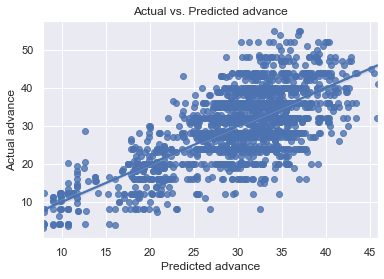

In [106]:
# a plot of predicted advance vs the actual advance
sns.regplot(x=prediction, y=j_df['advance'])
plt.xlabel("Predicted advance")
plt.ylabel("Actual advance")
plt.title("Actual vs. Predicted advance")
plt.show()

In [107]:
#Here i use SkLearn's Standard Scaler to scale all of our data to the same scale

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [108]:
X_train_scaled

,date_delta,three_rigs,four_rigs,weekly_headings,perc_trainee,perc_small
1650,1.286367,-0.816948,-0.251843,0.161964,0.467890,-1.190295
385,-1.041102,1.224069,-0.251843,-0.226904,-0.398567,0.237937
931,-0.036519,-0.816948,-0.251843,-0.032470,-0.398567,0.590357
1388,0.804314,-0.816948,-0.251843,0.939699,-0.398567,1.060252
347,-1.111019,-0.816948,-0.251843,-0.032470,-0.398567,0.563760
...,...,...,...,...,...,...
836,-0.211309,1.224069,-0.251843,0.356397,-0.398567,0.120463
1217,0.489692,-0.816948,-0.251843,-0.421337,3.717104,1.060252
1654,1.293727,1.224069,-0.251843,0.161964,-0.398567,-0.913304
559,-0.720960,1.224069,-0.251843,-0.226904,-0.398567,0.684336


In [109]:
def smols(X,y,cols=None):
    '''
    Uses Linear Regression to find a best fit given desired features.
    Arguments:
    X - dataframe
        Input features and values
    y - array-like
        Output values
    cols=None - list
        List of features to be included from the X dataframe
    Returns: OLS model. Use smols().summary() to view summary
    '''
    Xcol = X[cols]
    shmod = sm.OLS(endog=y, exog=sm.add_constant(Xcol)).fit()
    return shmod

In [110]:
#Create an OLS table for our final model
cols1 = ['date_delta','weekly_headings','perc_trainee','perc_small','three_rigs','four_rigs']
smols(X_train_scaled,y_train,cols1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                advance   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     246.4
Date:                Sun, 06 Nov 2022   Prob (F-statistic):          2.11e-219
Time:                        08:27:20   Log-Likelihood:                -5051.1
No. Observations:                1509   AIC:                         1.012e+04
Df Residuals:                    1502   BIC:                         1.015e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              29.7494      0.177    167.617      0.000      29.401      30.098
date_delta          1.6180      0.286      5.657      0.000       1.057       2.179
weekly_headings     4.6590      0.269     17.333      0.000       4.132       5.186
perc_trainee       -1.0707      0.208     -5.138      0.000      -1.479      -0.662
perc_small          1.3703      0.227      6.034      0.000       0.925       1.816
three_rigs          2.0112      0.189     10.613      0.000       1.640       2.383
four_rigs           1.1228      0.192      5.855      0.000       0.747       1.499
==============================================================================
Omnibus:                        1.700   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.427   Jarque-Bera (JB):                1.599
Skew:                          -0.055   Prob(JB):                        0.450
Kurtosis:                       3.116   Cond. No.                         3.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [111]:
def linpreds(X_tr_scaled, y_tr, X_te_scaled):
    '''
    Uses Linear Regression to generate output predictions given training and test inputs.
    Arguments:
    X_tr_scaled - dataframe
        Input variables and values for the training set
    y_tr - array-like
        Actual values for output variable, for the training set
    X_te_scaled - dataframe
        Input variables and values for the test set
    Returns:
    Output (y) prediction arrays:
        train, test
    '''
    lr = LinearRegression()
    lr.fit(X_tr_scaled, y_tr)
    return lr.predict(X_tr_scaled), lr.predict(X_te_scaled)

In [112]:
#Identify the MAE and RMSE for this model
Xftr1, Xfte1 = X_train[cols1], X_test[cols1]
trp1, tep1 = linpreds(Xftr1, y_train, Xfte1)
evaluate(y_train, y_test, trp1, tep1)

Train R2 score: 0.4960695589548205 
Test R2 score: 0.6101671104156517 

Train RMSE: 6.88 
Test RMSE: 6.16 

Train MAE: 5.45 
Test MAE: 4.78 


From these validations, i will be using the following features to make my predictor function:
- Weekly Headings
- Three Rigs
- Four Rigs
- % Small Headings
- % Trainees
- Date

In [113]:
#Scale the features dataframe i created earlier
scaler = StandardScaler()
scaler.fit(features)
features_scaled = scaler.transform(features)
features_scaled = pd.DataFrame(features_scaled, columns = features.columns, index=features.index)

In [114]:
features.head()

,date_delta,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs
0,0.0,4.0,0.0,0.0,0.0,0.0
1,4.0,4.0,0.0,0.0,0.0,0.0
2,5.0,4.0,0.0,0.0,0.0,0.0
3,8.0,2.0,0.0,0.0,0.0,0.0
4,9.0,2.0,0.0,0.0,0.0,0.0


In [115]:
features_scaled.head()

,date_delta,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs
0,-1.773881,-2.663017,-0.39761,-2.202679,-0.815776,-0.245178
1,-1.766558,-2.663017,-0.39761,-2.202679,-0.815776,-0.245178
2,-1.764727,-2.663017,-0.39761,-2.202679,-0.815776,-0.245178
3,-1.759235,-3.042931,-0.39761,-2.202679,-0.815776,-0.245178
4,-1.757405,-3.042931,-0.39761,-2.202679,-0.815776,-0.245178


In [116]:
#Fit this new scaled features dataframe and prediction dataframe to a model
final_model2 = LinearRegression()
final_model2.fit(features_scaled,prediction)

LinearRegression()

In [117]:
#Identifying standard deviation and mean of each feature for my prediction function
x = features
std_date, mean_date = np.std(x['date_delta']), np.mean(x['date_delta'])
std_hed, mean_hed = np.std(x['weekly_headings']), np.mean(x['weekly_headings'])
std_train, mean_train = np.std(x['perc_trainee']), np.mean(x['perc_trainee'])
std_sml, mean_sml = np.std(x['perc_small']), np.mean(x['perc_small'])
std_3, mean_3 = np.std(x['three_rigs']), np.mean(x['three_rigs'])
std_4, mean_4 = np.std(x['four_rigs']), np.mean(x['four_rigs'])

In [118]:
#Defining a std scaling function for my prediction function
def std_scale(x, x_mean, x_std):
    return ((x - x_mean) / x_std)

In [119]:
def predict_advance(small_headings,big_headings,rigs,frontliners,trainees,start_date):
    '''
    
    small_headings = the quantity of small headings in the weekly schedule
    big_headings = the quantity of small headings in the weekly schedule
    rigs = the quantity of jumbos we have this week
    frontliners = the quantity of frontline operators we have this week
    trainees = the quantity of trainee operators we have this week
    start_date = the start date of our week in format 'DD/MM/YY'
    
    '''
    
    #Import datetime module
    from datetime import datetime
    
    #Determine a non scaled amount of weekly headings
    weekly_headings_ns = small_headings + big_headings
   
    #Determine non scaled values for amount of rigs
    if rigs == 4:
        four_rigs_ns = 1
    else: four_rigs_ns = 0
    if rigs == 3:
        three_rigs_ns = 1
    else: three_rigs_ns = 0
    
    #Determine non scaled percentage of trainees and small headinsg
    perc_trainee_ns = trainees / (frontliners + trainees)
    perc_small_ns = small_headings / (small_headings + big_headings)
    
    #Determine a non scaled amount of days from the start of contract to our current date
    date_delta1_ns = (datetime.strptime(start_date,'%d/%m/%y') - datetime.strptime('5/7/17','%d/%m/%y')).days
    #Do the same for the  next 6 days
    date_delta2_ns = date_delta1_ns + 1
    date_delta3_ns = date_delta2_ns + 1
    date_delta4_ns = date_delta3_ns + 1
    date_delta5_ns = date_delta4_ns + 1
    date_delta6_ns = date_delta5_ns + 1
    date_delta7_ns = date_delta6_ns + 1
    
    #Scale all of the date deltas
    date_delta1 = std_scale(date_delta1_ns, mean_date, std_date)
    date_delta2 = std_scale(date_delta2_ns, mean_date, std_date)
    date_delta3 = std_scale(date_delta3_ns, mean_date, std_date)
    date_delta4 = std_scale(date_delta4_ns, mean_date, std_date)
    date_delta5 = std_scale(date_delta5_ns, mean_date, std_date)
    date_delta6 = std_scale(date_delta6_ns, mean_date, std_date)
    date_delta7 = std_scale(date_delta7_ns, mean_date, std_date)
    
    #scale every other feature
    weekly_headings = std_scale(weekly_headings_ns, mean_hed, std_hed)
    perc_trainee = std_scale(perc_trainee_ns, mean_train, std_train)
    perc_small = std_scale(perc_small_ns, mean_sml, std_sml)
    three_rigs = std_scale(three_rigs_ns, mean_3, std_3)
    four_rigs = std_scale(four_rigs_ns, mean_4, std_4)
    
    #Run the prediction function for the model for each date delta
    X1 = [[date_delta1,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv1 = final_model2.predict(X1)
    X2 = [[date_delta2,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv2 = final_model2.predict(X2)
    X3 = [[date_delta3,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv3 = final_model2.predict(X3)
    X4 = [[date_delta4,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv4 = final_model2.predict(X4)
    X5 = [[date_delta5,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv5 = final_model2.predict(X5)
    X6 = [[date_delta6,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv6 = final_model2.predict(X6)
    X7 = [[date_delta7,weekly_headings,perc_trainee,perc_small,three_rigs,four_rigs]]
    adv7 = final_model2.predict(X7)
    
    #Sum up the advances for the week
    advance = adv1 + adv2 + adv3 + adv4 + adv5 + adv6 + adv7
    
    #print
    print(round(float(advance),1),'metres')

In [120]:
# Lets use the feature values from the current week's schedule..
predict_advance(small_headings=8,
               big_headings=8,
                rigs=4,
                frontliners=8,
                trainees=0,
               start_date='2/11/22')

233.5 metres


So our model has predicted 233.5m for the week.
thats an average of 33.36 a day

This week so far (in real life) we are averaging 33.73m a day

This is a great result!
